In [1]:
import numpy as np
import torch
import torch.nn as nn
from utils import FakeDL, eigenspace_stability
import algos.pyhessian as pyhessian 

import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.use('Agg')

from phicomp import comp_phi

device = "cpu"

In [2]:
def get_dataset(n, d):
    # assert n >= d
    X = np.sqrt(n) * torch.qr(torch.normal(torch.zeros(n, d)))[0]

    # Can be changed to sqrt(d) * I as suggested
    # A = torch.normal(torch.zeros(d, d))
    A = torch.eye(d) * np.sqrt(d)
    # A = torch.eye(d)
    Y = torch.matmul(X, A)
    return X, Y

In [3]:
class LinearNet(nn.Module):
    def __init__(self, L, d):
        super(LinearNet, self).__init__()
        self.L = L
        self.layers = []
        for i in range(L):
            # For dimension debugging
            # if i == L - 1:
            #     self.layers.append(nn.Linear(d + i * 1, d, bias=False))
            # else:
            #     self.layers.append(nn.Linear(d + i * 1, d + (i + 1) * 1, bias=False))
            self.layers.append(nn.Linear(d, d, bias=False))
            self.add_module("W{}".format(i+1), self.layers[-1])

    def forward(self, x):
        for i in range(self.L):
            x = self.layers[i](x)
        return x

In [4]:
def compute_eigeninfo(net, dl, topn, criterion):
    # Computing the top n eigenvectors using Power Iteration Method.
    net.eval()
    hessian_comp = pyhessian.hessian(net, criterion, dataloader=dl, cuda=False if device=="cpu" else True)
    eigenvals, eigenvecs = hessian_comp.eigenvalues(top_n=topn, tol=1e-4, maxIter=1000)
    # print(eigenvals)
    net.train()
    return eigenvals, eigenvecs

def quadratic_loss(Y_hat, Y):
    """Batched quadratic loss"""
    diff = torch.square(Y - Y_hat)
    loss = diff.sum() * 0.5
    if len(Y_hat.shape) != 1:
        loss /= len(Y)
    return loss

In [50]:
seed, eval_start, eval_end = 2333, 2000, 2600
freq = 1

torch.manual_seed(seed)
# Configs, current set as proposed in the paper
d = 10 # layer width
n = 10 # # of samples
L = 10 # # of layers
hessian_topn = 2

X, Y = get_dataset(n, d)
X, Y = X.to(device), Y.to(device)

eta = 2/1000
epochs = eval_end
hessian_eval_epochs = list(range(eval_start, eval_end, freq))

dataloader = FakeDL(X, Y, device)
loss_record = []
eigenvals_record = []
eigenvecs_record = []

eigenval1_Phi = []
eigenval2_Phi = []
weight_record = []
Y_record = []

net = LinearNet(L, d).to(device)
# Xavier Initialization
# for param in net.parameters():
#     param.data = torch.normal(torch.zeros_like(param), 1/np.sqrt(d)) # pylint: disable=no-member
for layer in net.layers:
    nn.init.xavier_normal_(layer.weight)

# criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(net.parameters(), lr=eta)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    
    Y_hat = net(X)
    # loss = criterion(Y_hat, Y)
    loss = quadratic_loss(Y_hat, Y)
    # exit()
    
    loss.backward()
    optimizer.step()
    
    loss_record.append(loss.item())

    if epoch in hessian_eval_epochs:
        eigenvals, eigenvecs = compute_eigeninfo(net, dataloader, hessian_topn, quadratic_loss)
        eigenvals_record.append(eigenvals)
        eigenvecs_record.append(eigenvecs)

        Ws = [W.weight.data.clone() for W in net.layers]
        W_prod = Ws[0].clone()
        for W in Ws[1:]:
            W_prod = W.matmul(W_prod)
        
        weight_record.append(Ws)
        Y_record.append(Y_hat)

        # Phi and flattest hessian availble here
        Phi = comp_phi(Ws)
        H_flattest_min = Phi.matmul(Phi.T) # (since we are using the loss function from 2103.00065 with a half)
        phi_val1, phi_val2 = torch.svd(H_flattest_min, compute_uv=True)[1][0], torch.svd(H_flattest_min, compute_uv=True)[1][1]
        eigenval1_Phi.append(phi_val1)
        eigenval2_Phi.append(phi_val2)
        # print(H_flattest_min.shape)

    if epoch % 100 == 0:
        print("Epoch {} \t Loss: {:.6g} \t Sharpness: {:.6g}".format(epoch, loss.item(), eigenvals_record[-1][0] if len(eigenvals_record) > 0 else -1))

Epoch 0 	 Loss: 74.2584 	 Sharpness: -1
Epoch 100 	 Loss: 29.7952 	 Sharpness: -1
Epoch 200 	 Loss: 25.2172 	 Sharpness: -1
Epoch 300 	 Loss: 24.9394 	 Sharpness: -1
Epoch 400 	 Loss: 24.8178 	 Sharpness: -1
Epoch 500 	 Loss: 24.4986 	 Sharpness: -1
Epoch 600 	 Loss: 20.0402 	 Sharpness: -1
Epoch 700 	 Loss: 19.9981 	 Sharpness: -1
Epoch 800 	 Loss: 19.9975 	 Sharpness: -1
Epoch 900 	 Loss: 19.9969 	 Sharpness: -1
Epoch 1000 	 Loss: 19.9962 	 Sharpness: -1
Epoch 1100 	 Loss: 19.9954 	 Sharpness: -1
Epoch 1200 	 Loss: 19.9944 	 Sharpness: -1
Epoch 1300 	 Loss: 19.9932 	 Sharpness: -1
Epoch 1400 	 Loss: 19.9916 	 Sharpness: -1
Epoch 1500 	 Loss: 19.9895 	 Sharpness: -1
Epoch 1600 	 Loss: 19.9866 	 Sharpness: -1
Epoch 1700 	 Loss: 19.9824 	 Sharpness: -1
Epoch 1800 	 Loss: 19.9759 	 Sharpness: -1
Epoch 1900 	 Loss: 19.9648 	 Sharpness: -1
Epoch 2000 	 Loss: 19.9426 	 Sharpness: 984.353
Epoch 2100 	 Loss: 19.8829 	 Sharpness: 982.781
Epoch 2200 	 Loss: 19.5341 	 Sharpness: 979.231
Epoch 23

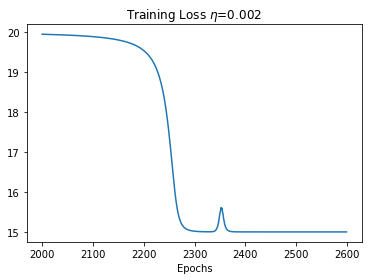

In [35]:
%matplotlib inline
# Plot the empirical loss
plt.plot(np.arange(len(loss_record))[eval_start:eval_end], loss_record[eval_start:eval_end], label=r'$\eta$={:.4g}'.format(eta))
plt.title(r"Training Loss $\eta$={:.4g}".format(eta))
plt.xlabel('Epochs')
plt.show()

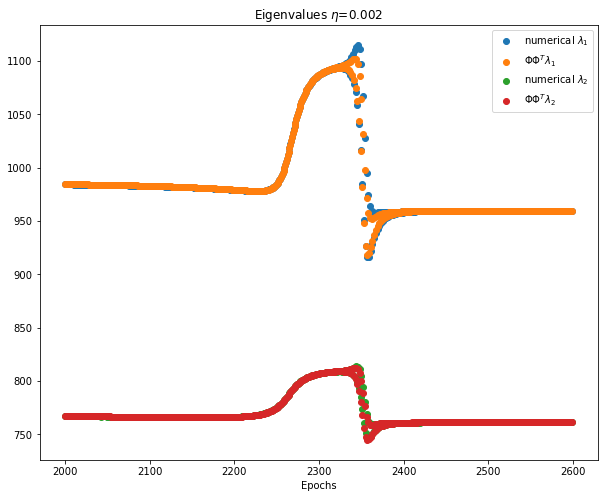

In [54]:
plt.figure(figsize=(10,8))
plt.scatter(hessian_eval_epochs, [v[0] for v in eigenvals_record], label=r'numerical $\lambda_1$')
plt.scatter(hessian_eval_epochs, eigenval1_Phi, label=r'$\Phi\Phi^T \lambda_1$')

plt.scatter(hessian_eval_epochs, [v[1] for v in eigenvals_record], label=r'numerical $\lambda_2$')
plt.scatter(hessian_eval_epochs, eigenval2_Phi, label=r'$\Phi\Phi^T \lambda_2$')
plt.legend()
# plt.ylim([880, 1150])
plt.title(r"Eigenvalues $\eta$={:.4g}".format(eta))
plt.xlabel('Epochs')
plt.show()

In [17]:
def get_equiv_weight(Ws):
    W_prod = Ws[0].clone()
    for W in Ws[1:]:
        W_prod = W.matmul(W_prod)
    return W_prod

def get_param(Ws):
    W_param = torch.cat([x.view(-1) for x in Ws])
    return W_param

In [10]:
W_prod = get_equiv_weight(Ws)

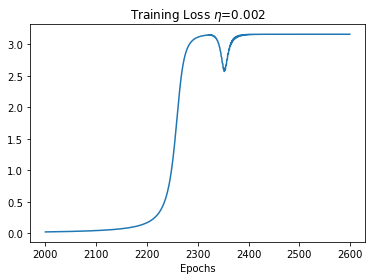

In [55]:
# the newly learnt eigenvalues
new_eigenvals = []
for Ws in weight_record:
    W_prod = get_equiv_weight(Ws)
    _, D, _ = torch.svd(W_prod, compute_uv=False)
    new_eigenvals.append(D[-4])

plt.plot(hessian_eval_epochs, new_eigenvals, label=r'$\eta$={:.4g}'.format(eta))
plt.title(r"Training Loss $\eta$={:.4g}".format(eta))
plt.xlabel('Epochs')
plt.show()

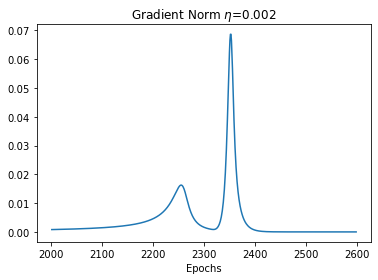

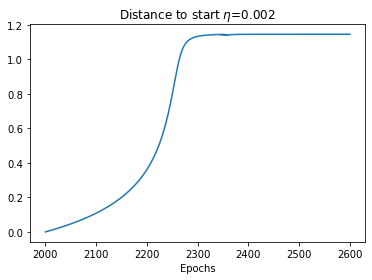

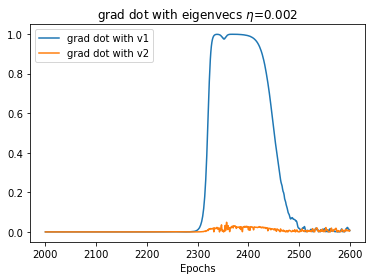

In [59]:
# gradient and distance
gradient_norms = []
norm_to_start = []

dot_with_eigenvec1 = []
dot_with_eigenvec2 = []

W_init = get_param(weight_record[0])
W_prev = get_param(weight_record[0])

grads = []
for i, Ws in enumerate(weight_record[1:]):
    W_param = get_param(Ws)
    grad = W_param - W_prev
    gradient_norms.append(torch.norm(grad))
    norm_to_start.append(torch.norm(W_param - W_init))

    eigenvec1 = torch.cat([x.view(-1) for x in eigenvecs_record[i + 1][0]])
    eigenvec2 = torch.cat([x.view(-1) for x in eigenvecs_record[i + 1][1]])
    normalized_grad = grad / torch.norm(grad)
    dot_with_eigenvec1.append(torch.abs(torch.dot(normalized_grad, eigenvec1)))
    dot_with_eigenvec2.append(torch.abs(torch.dot(normalized_grad, eigenvec2)))

    W_prev = W_param
    grads.append(grad)


plt.plot(hessian_eval_epochs[1:], gradient_norms, label=r'$\eta$={:.4g}'.format(eta))
plt.title(r"Gradient Norm $\eta$={:.4g}".format(eta))
plt.xlabel('Epochs')
plt.show()

plt.plot(hessian_eval_epochs[1:], norm_to_start, label=r'$\eta$={:.4g}'.format(eta))
plt.title(r"Distance to start $\eta$={:.4g}".format(eta))
plt.xlabel('Epochs')
plt.show()

plt.plot(hessian_eval_epochs[1:], dot_with_eigenvec1, label='grad dot with v1'.format(eta))
plt.plot(hessian_eval_epochs[1:], dot_with_eigenvec2, label='grad dot with v2'.format(eta))
plt.title(r"grad dot with eigenvecs $\eta$={:.4g}".format(eta))
plt.legend()
plt.xlabel('Epochs')
plt.show()

In [ ]:
grad_init = grads[0] / torch.norm(grads[0])
grad_dots = []

for grad in grad[1:]:
    grad_dots.append(grad.dot(grad_init))